This was my 6th attempt to get my code working for the time-series-analysis project. It does not run, but it does look interesting.

This notebook was written based on these resources:
https://www.kaggle.com/code/someadityamandal/bitcoin-time-series-forecasting/notebook
https://github.com/dataquestio/project-walkthroughs/tree/master/bitcoin_price
https://www.geeksforgeeks.org/time-series-forecasting-using-tensorflow/

Special thank you to David for, as always, having the best resources.

In [28]:
import numpy as np
import pandas as pd
import keras.layers as layers
import keras.models as models

import datetime, pytz
from sklearn.preprocessing import MinMaxScaler

import os
print(os.listdir('./data'))

['coinbaseUSD.csv', 'bitstampUSD.csv']


In [29]:
def dateparse(time_in_secs):
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))

data = pd.read_csv('./data/coinbaseUSD.csv', parse_dates=[0], date_parser=dateparse)

data.info()
print(data.head)

/tmp/ipykernel_322471/176637671.py:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv('./data/coinbaseUSD.csv', parse_dates=[0], date_parser=dateparse)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2099760 entries, 0 to 2099759
Data columns (total 8 columns):
 #   Column             Dtype              
---  ------             -----              
 0   Timestamp          datetime64[ns, UTC]
 1   Open               float64            
 2   High               float64            
 3   Low                float64            
 4   Close              float64            
 5   Volume_(BTC)       float64            
 6   Volume_(Currency)  float64            
 7   Weighted_Price     float64            
dtypes: datetime64[ns, UTC](1), float64(7)
memory usage: 128.2 MB
<bound method NDFrame.head of                         Timestamp     Open     High      Low    Close  \
0       2014-11-30 23:33:00+00:00   300.00   300.00   300.00   300.00   
1       2014-11-30 23:34:00+00:00      NaN      NaN      NaN      NaN   
2       2014-11-30 23:35:00+00:00      NaN      NaN      NaN      NaN   
3       2014-11-30 23:36:00+00:00      NaN      NaN      NaN

In [30]:
data['Volume_(BTC)'].fillna(value=0, inplace=True)
data['Volume_(Currency)'].fillna(value=0, inplace=True)
data['Weighted_Price'].fillna(value=0, inplace=True)

data['Open'].fillna(method='ffill', inplace=True)
data['High'].fillna(method='ffill', inplace=True)
data['Low'].fillna(method='ffill', inplace=True)
data['Close'].fillna(method='ffill', inplace=True)

print(data.head())

                  Timestamp   Open   High    Low  Close  Volume_(BTC)  \
0 2014-11-30 23:33:00+00:00  300.0  300.0  300.0  300.0          0.01   
1 2014-11-30 23:34:00+00:00  300.0  300.0  300.0  300.0          0.00   
2 2014-11-30 23:35:00+00:00  300.0  300.0  300.0  300.0          0.00   
3 2014-11-30 23:36:00+00:00  300.0  300.0  300.0  300.0          0.00   
4 2014-11-30 23:37:00+00:00  300.0  300.0  300.0  300.0          0.00   

   Volume_(Currency)  Weighted_Price  
0                3.0           300.0  
1                0.0             0.0  
2                0.0             0.0  
3                0.0             0.0  
4                0.0             0.0  


/tmp/ipykernel_322471/537992000.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Volume_(BTC)'].fillna(value=0, inplace=True)
/tmp/ipykernel_322471/537992000.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

In [31]:
start = datetime.datetime(2015, 1, 1, 0,0,0,0, pytz.UTC)
end = datetime.datetime(2018, 11,11,0,0,0,0, pytz.UTC)

weekly_rows = data[(data['Timestamp'] >= start) & (
    data['Timestamp'] <= end)].groupby(
        [pd.Grouper(key='Timestamp', freq='W-MON')]
    ).first().reset_index()

print(weekly_rows.head())

                  Timestamp    Open    High     Low   Close  Volume_(BTC)  \
0 2015-01-12 00:00:00+00:00  360.00  360.00  360.00  360.00         0.010   
1 2015-01-19 00:00:00+00:00  260.00  260.00  260.00  260.00         0.000   
2 2015-01-26 00:00:00+00:00  225.51  225.51  225.51  225.51         0.000   
3 2015-02-02 00:00:00+00:00  259.99  259.99  259.99  259.99         0.300   
4 2015-02-09 00:00:00+00:00  239.28  239.50  239.28  239.50        20.675   

   Volume_(Currency)  Weighted_Price  
0           3.600000      360.000000  
1           0.000000        0.000000  
2           0.000000        0.000000  
3          77.997000      259.990000  
4        4951.178693      239.476599  


In [32]:
data = pd.read_csv('./data/coinbaseUSD.csv', parse_dates=[0], date_parser=dateparse)
data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)

data = data.groupby([pd.Grouper(key='Timestamp', freq='H')]).first().reset_index()

data = data.set_index('Timestamp')
data = data[['Weighted_Price']]
data['Weighted_Price'].fillna(method='ffill', inplace=True)

/tmp/ipykernel_322471/105282266.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv('./data/coinbaseUSD.csv', parse_dates=[0], date_parser=dateparse)
/tmp/ipykernel_322471/105282266.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.groupby([pd.Grouper(key='Timestamp', freq='H')]).first().reset_index()
/tmp/ipykernel_322471/105282266.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[co

In [33]:
split_date = '25-Jun-2018'

data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

In [34]:
training_set = data_train.values
training_set = np.reshape(training_set, (len(training_set), 1))

sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

In [35]:
model1 = models.Sequential()

model1.add(layers.LSTM(128, activation='relu', input_shape=(1, 1)))
model1.add(layers.Dense(1))
model1.compile(loss='mean_squared_error', optimizer='adam')
model1.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2)

model2 = models.Sequential()

# This one's more promising than the other's I've seen
model2.add(layers.LSTM(128, activation='relu', input_shape=(1, 1), return_sequences=True))
model2.add(layers.LSTM(128, activation='relu', input_shape=(1, 1), return_sequences=True))
model2.add(layers.LSTM(64))
model2.add(layers.Dense(8, activation='relu'))
model2.add(layers.Dense(1, activation= 'linear'))
# Interesting that this one does two different activation functions
# Suppose that makes sense though

# Ok last one is that weird amalgamation I did last time.
# Copy and pasting isn't cheating when it's your own code
model3 = models.Sequential()

model3.add(layers.LSTM(128, activation='relu', input_shape=(1, 1)))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(1))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(1))
model3.compile(loss='mean_squared_error', optimizer='adam')
model3.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
625/625 - 5s - 7ms/step - loss: 0.0068
Epoch 2/100
625/625 - 2s - 3ms/step - loss: 5.2591e-05
Epoch 3/100
625/625 - 2s - 3ms/step - loss: 2.7363e-05
Epoch 4/100
625/625 - 2s - 3ms/step - loss: 1.4070e-05
Epoch 5/100
625/625 - 2s - 3ms/step - loss: 1.1396e-05
Epoch 6/100
625/625 - 2s - 3ms/step - loss: 1.1360e-05
Epoch 7/100
625/625 - 2s - 3ms/step - loss: 1.1490e-05
Epoch 8/100
625/625 - 3s - 4ms/step - loss: 1.1581e-05
Epoch 9/100
625/625 - 2s - 4ms/step - loss: 1.1832e-05
Epoch 10/100
625/625 - 2s - 4ms/step - loss: 1.2361e-05
Epoch 11/100
625/625 - 2s - 3ms/step - loss: 1.2381e-05
Epoch 12/100
625/625 - 3s - 5ms/step - loss: 1.2023e-05
Epoch 13/100
625/625 - 2s - 4ms/step - loss: 1.2020e-05
Epoch 14/100
625/625 - 2s - 3ms/step - loss: 1.2366e-05
Epoch 15/100
625/625 - 2s - 3ms/step - loss: 1.2321e-05
Epoch 16/100
625/625 - 2s - 4ms/step - loss: 1.2378e-05
Epoch 17/100
625/625 - 2s - 4ms/step - loss: 1.2112e-05
Epoch 18/100
625/625 - 3s - 5ms/step - loss: 1.2186e-05
Epoch

Not so distant future Ace here to remind further future Ace that they can restructure these notebooks to be a bit more efficient.
This is the third time in this specific notebook that I've trained these models, all because I keep resetting the kernels to run predictions further down.
Also, further future Ace, have you figured out how to make it to where your discord is synced with VS Code? Because that would be a good way to be held accountable.

In [36]:
model1.summary()
model2.summary()
model3.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,069 (781.52 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 133,380 (521.02 KB)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 1, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 1, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 248,081 (969.07 KB)

 Trainable params: 248,081 (969.07 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,075 (781.55 KB)

 Trainable params: 66,691 (260.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 133,384 (521.04 KB)

In [ ]:
# For posterities sake, we're gonna try the vizualization from V5
# Just to see if anything changed.
#   Actually we're gonna give the predictions from the og tutorial a try.
#   This kernel is for the first model.

test_set = data_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))

predicted_BTC_price = model1.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

data_test['Weighted_Price_Prediction'] = predicted_BTC_price
data_all = pd.concat([data_test, data_train], sort=False)
# Oh nice! That ran! Maybe a model will show up?

In [ ]:
# This is for the second model.
#   Ah, looks like I'll have to figure out how input sizes and whatnot works
#   Because this is the crux of the issue I've had this past week.
#   Looks like the second model is something to be revisited.
#   Or maybe I just need to clear outputs?
#   Yep that's exactly what needed to happen.
#   Look at me! Learning things!
#   This one has a new issue though, in that it just... didn't make a prediction.
#   Like. It just gave up
#   I relate.

test_set = data_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))

predicted_BTC_price = model2.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

data_test['Weighted_Price_Prediction'] = predicted_BTC_price
data_all = pd.concat([data_test, data_train], sort=False)

In [37]:
# Third model. Idk if this'll go through either but it's worth a try.
test_set = data_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))

predicted_BTC_price = model3.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

data_test['Weighted_Price_Prediction'] = predicted_BTC_price
data_all = pd.concat([data_test, data_train], sort=False)

148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


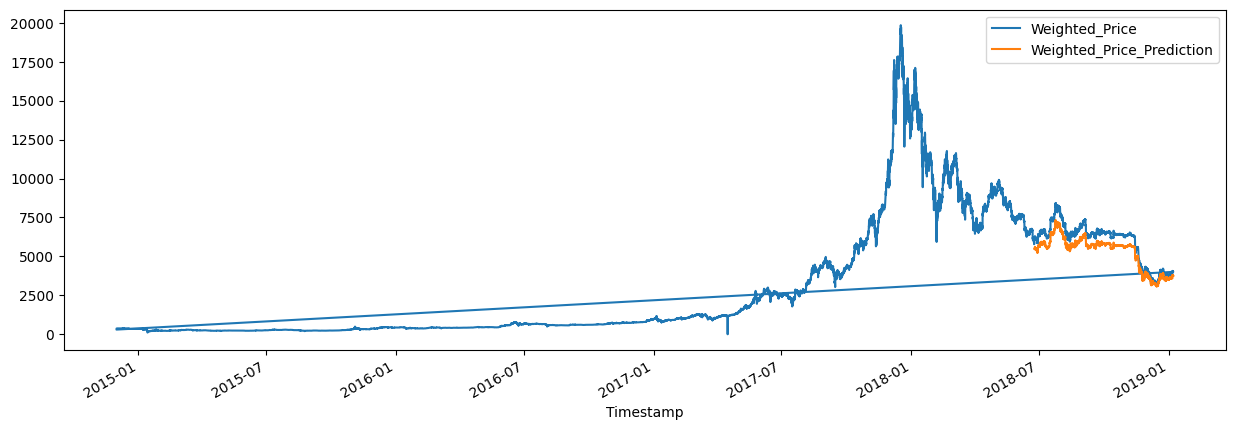

In [38]:
final_data = data_all
final_data = final_data.reset_index()
final_data = final_data.rename(columns={'Weighted_Price_Prediction': 'lstm'})
final_data = final_data[['Timestamp', 'Weighted_Price', 'lstm']]

_ = data_all[['Weighted_Price', 'Weighted_Price_Prediction']].plot(figsize=(15, 5))

Ok so it's still got that weird line and doesn't show the actual numbers. But honestly? I'm only just now realizing that I didn't actually load them anywhere? Maybe?
Anyway, let's run the other models, yeah?

Ah, leave it up to me to not scroll down in the tutorial and see how he charts the actual prices against the predictions.
Sajid, if you're reading this, I /will/ be finishing this project, regardless of if it gets graded. I'll still want your input on it though.

Looks like the weird amalgamation I made fared better, but that's still a suspicious looking result. Anyway, thanks for reading through my patchwork code!